In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import IMREAD_GRAYSCALE
import os
from scipy.signal import convolve
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian

### Leung man filter bank

In [2]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

### Creating features

In [3]:
def feature_engineering(img, img_name, inferrence= False):
    df = pd.DataFrame()

    df['og_pixels'] = img.reshape(-1)
    df['img'] = img_name

    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    gabor_label = 'gabor_' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype= cv2.CV_32F)
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    num += 1

    # F = makeLMfilters()
    # _, _, num_filters = F.shape
    # for i in range(num_filters):
    #     df[f'lm_filter_{i}'] = convolve(img, F[:,:,i], mode='same').reshape(-1)

    edges = cv2.Canny(img, 100, 200)
    edges1 = edges.reshape(-1)
    df['canny'] = edges1

    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['roberts'] = edge_roberts1

    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['sobel'] = edge_sobel1

    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['scharr'] = edge_scharr1

    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['prewitt'] = edge_prewitt1

    gaussian_img = gaussian(img, 3)
    df['gaussian_s3'] = gaussian_img.reshape(-1)

    gaussian_img2 = gaussian(img, 7)
    df['gaussian_s7'] = gaussian_img2.reshape(-1)


    median_img = cv2.medianBlur(img, 3)
    df['median_s3'] = median_img.reshape(-1)

    if inferrence:
        df = df.drop('img', axis= 1)

    return df

In [4]:
def crop_center(img, crop_amount= 100):
    center = img.shape
    w = center[1] - 100
    h = center[0] - 100
    x = center[1]/2 + 10 - w/2
    y = center[0]/2 + 5 - h/2
    return img[int(y):int(y+h), int(x):int(x+w)]

### Loading train images (total of 9)

In [5]:
train_df = pd.DataFrame()
train_path = './train/train.tif'

In [6]:
_, train_img = cv2.imreadmulti(train_path, [])

for img_name, img in enumerate(train_img):
    img_name = str(img_name) + '.jpg'
    print(f'Loading {img_name}')
    img = crop_center(img)
    df = feature_engineering(img, img_name)
    train_df = pd.concat([train_df, df])
train_df


Loading 0.jpg
Loading 1.jpg
Loading 2.jpg
Loading 3.jpg
Loading 4.jpg
Loading 5.jpg
Loading 6.jpg
Loading 7.jpg
Loading 8.jpg


,og_pixels,img,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827899,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
827900,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
827901,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
827902,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Doing mini-batching (WIP, not applicable for random forest)

In [7]:
# def get_mini_batch(train_path, label_path):
#     _, train_img = cv2.imreadmulti(train_path, [])
#     _, train_label_img = cv2.imreadmulti(label_path, [])
#     df = pd.DataFrame()
#     _, _, len_dataset = train_img.shape
#     for i in range(len_dataset):
#         img = train_img[:, :, i]
#         label = train_label_img[:, :, i]
#         df = feature_engineering(img, f'batch {i + 1}')
#         df['label'] = label.reshape(-1)
#         yield df.drop(['img', 'label'], axis= 1), df['label'].values 
    

### Loading label (using only 1 tif file)

In [8]:
train_label_df = pd.DataFrame()
train_label_path = './labels/label.tif'

In [9]:


_, train_label_img = cv2.imreadmulti(train_label_path, [])

for label_name, label_img in enumerate(train_label_img):
    label_name = str(label_name) + '.jpg'
    df = pd.DataFrame()

    label_img = crop_center(label_img)
    
    df['label'] = label_img.reshape(-1)
    df['img_label'] = label_name

    train_label_df = pd.concat([train_label_df, df])
train_label_df

,label,img_label
0,0,0.jpg
1,0,0.jpg
2,0,0.jpg
3,0,0.jpg
4,0,0.jpg
...,...,...
827899,0,8.jpg
827900,0,8.jpg
827901,0,8.jpg
827902,0,8.jpg


### Loading using 4 tiff file as 4 classes

In [10]:
# train_label_df = pd.DataFrame()
# train_label_path = './labels/'

In [11]:
# _, label_2 = cv2.imreadmulti(os.path.join(train_label_path, 'label_2.tiff'))
# _, label_3 = cv2.imreadmulti(os.path.join(train_label_path, 'label_3.tiff'))
# _, label_4 = cv2.imreadmulti(os.path.join(train_label_path, 'label_4.tiff'))

In [12]:
# for i in range(len(label_2)):
#     img_name = str(i) + '.jpg'
#     df = pd.DataFrame()

#     label = np.where(label_2[i] != 0, 1, 0)
#     label = np.where(label_3[i] != 0, 2, label)
#     label = np.where(label_4[i] != 0, 3, label)
    
#     df['label'] = label.reshape(-1)
#     df['img_label'] = img_name
#     train_label_df = pd.concat([train_label_df, df])
# train_label_df

### Concat train data with label

In [13]:
data_df = pd.concat([train_df, train_label_df], axis= 1)

data_df['img'].equals(data_df['img_label'])

True

### Drop 0 as the 1 tiff file only need designated label of 1 to 4 to be trained

In [14]:
data_df = data_df[data_df['label'] != 0]

### Creating group index for LOGO cross validition

In [15]:
group = data_df.groupby('img').ngroup()
group

434       0
435       0
436       0
437       0
438       0
         ..
773843    8
773844    8
773845    8
773846    8
773847    8
Length: 313757, dtype: int64

### Extracting X and Y

In [16]:
X = data_df.drop(['img', 'img_label','label'], axis= 1).reset_index(drop= True)
Y = data_df['label'].values

In [17]:
X

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,27,0,0,71,37,13,6,0,0,0,...,51,36,0,0.061570,0.058274,0.060422,0.055490,0.104920,0.122716,24
1,34,0,0,139,84,72,46,52,34,0,...,46,32,0,0.041963,0.029248,0.028803,0.029937,0.100748,0.120607,26
2,26,0,0,112,64,19,14,0,0,0,...,23,14,0,0.024802,0.046037,0.048560,0.042679,0.098503,0.118737,24
3,15,0,0,134,59,53,20,34,11,0,...,20,12,0,0.015686,0.025110,0.027355,0.022203,0.097983,0.117126,18
4,14,0,0,140,61,36,13,2,0,0,...,24,13,0,0.039703,0.025206,0.024857,0.025682,0.098909,0.115780,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313752,154,0,0,255,255,254,146,109,66,0,...,86,55,0,0.023854,0.018653,0.018874,0.018486,0.546654,0.436508,149
313753,146,0,0,255,255,247,132,103,51,0,...,74,42,0,0.014139,0.014739,0.013660,0.016353,0.549833,0.432962,149
313754,150,0,0,255,255,226,125,86,49,0,...,66,33,0,0.011765,0.014706,0.018873,0.009150,0.551589,0.428366,149
313755,154,0,0,255,255,231,126,90,47,0,...,98,61,0,0.041595,0.034314,0.034167,0.034511,0.550889,0.422649,151


In [18]:
np.unique(Y)

array([1, 2, 3, 4], dtype=uint8)

### Creating model and cross validating

In [19]:
from sklearn.model_selection import cross_validate, cross_val_predict, LeaveOneGroupOut
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_curve
from itertools import cycle

def cross_validation(model, _X, _Y, _groups, _scoring, _threads= 1):
    print('start validating')

    logo = LeaveOneGroupOut()

    y_bin = label_binarize(_Y, classes= [1, 2, 3, 4])
    n_classes = y_bin.shape[1]

    scores = cross_validate(model, _X, _Y, groups= _groups, scoring= _scoring, cv= logo, n_jobs= _threads, verbose= 1)

    y_scores = cross_val_predict(model, _X, _Y, groups= _groups, cv= logo, method= 'predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1, n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    classes = {
        0: 'Air',
        1: 'Clay',
        2: 'Quartz',
        3: 'Pyrite'
    }
    for i, color in zip(range(1, n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes.get(i), roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

    result = {}
    for metric in scores:
        result[metric] = scores[metric]
        result[metric + '__mean'] = scores[metric].mean()
        result[metric + '__standard-deviation'] = scores[metric].std()
    return result

start training


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s


start validating


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.5s
[Parallel(n_

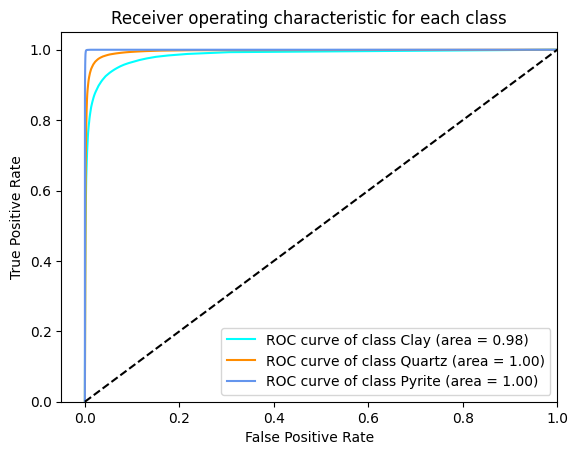

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 50, random_state= 42, verbose= 1, n_jobs= -1)

print('start training')
model.fit(X, Y)

scoring = ['accuracy', 'f1_macro', 'jaccard_macro']

score = cross_validation(model, X, Y, group, scoring, 8)



In [21]:
score

{'fit_time': array([48.9217279 , 52.74927139, 53.93651843, 52.09311366, 52.641361  ,
        54.29667377, 52.06101823, 56.41783929, 10.33202744]),
 'fit_time__mean': 48.161061233944366,
 'fit_time__standard-deviation': 13.509609345957621,
 'score_time': array([1.37322521, 0.89950156, 0.81408143, 0.83327103, 0.57932353,
        0.71503472, 0.82282114, 0.42942643, 0.05955744]),
 'score_time__mean': 0.7251380549536811,
 'score_time__standard-deviation': 0.33852164210210883,
 'test_accuracy': array([0.9528668 , 0.96081808, 0.94618276, 0.92841445, 0.93485915,
        0.95301441, 0.93612497, 0.97394753, 0.95335491]),
 'test_accuracy__mean': 0.9488425645663702,
 'test_accuracy__standard-deviation': 0.013371975626146967,
 'test_f1_macro': array([0.94450816, 0.95900479, 0.9093414 , 0.9021023 , 0.93592623,
        0.96122618, 0.94400113, 0.95888234, 0.93023251]),
 'test_f1_macro__mean': 0.9383583361343667,
 'test_f1_macro__standard-deviation': 0.020189483041775435,
 'test_jaccard_macro': array([

### Doing inference for testing output

In [22]:
_, img_test_list = cv2.imreadmulti(train_path)
img_test = img_test_list[0]
img_test_df = feature_engineering(img_test, 'test.jpg', True)
img_test_df

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [23]:
segmented_img_test = model.predict(img_test_df)
segmented_img_test = segmented_img_test.reshape((img_test.shape))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    1.5s finished


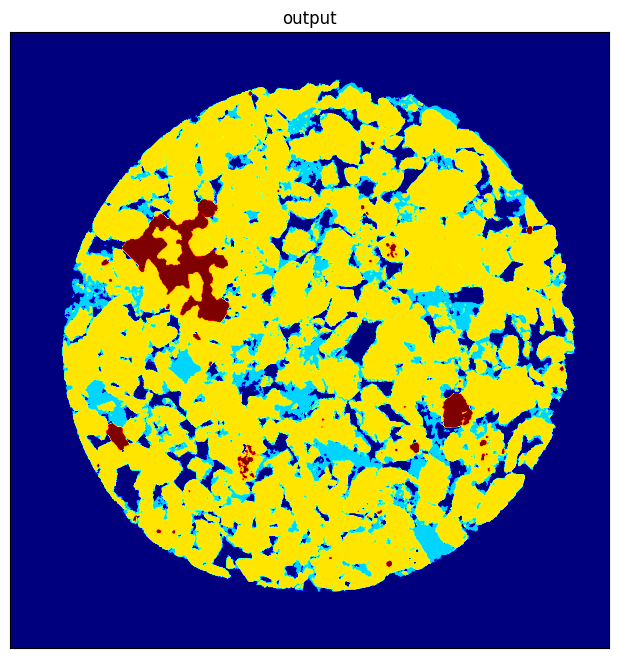

In [24]:
plt.figure(figsize=(8, 8))
fig = plt.imshow(segmented_img_test, cmap= 'jet')
plt.title('output')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [25]:
import pickle


model_name = "random_forest"
pickle.dump(model, open(model_name, 'wb'))

In [26]:
sorted(zip(model.feature_importances_, img_test_df.columns), reverse= True)

[(0.18404302794204525, 'median_s3'),
 (0.15558052998278543, 'gaussian_s3'),
 (0.10539174186648498, 'og_pixels'),
 (0.09632378007015374, 'gaussian_s7'),
 (0.08138494198404715, 'gabor_4'),
 (0.07379255125899836, 'gabor_6'),
 (0.035060500145009506, 'gabor_3'),
 (0.03247119051055714, 'gabor_5'),
 (0.026808259449627073, 'gabor_8'),
 (0.026226180783626315, 'gabor_23'),
 (0.020856753351788236, 'gabor_24'),
 (0.019135386756873474, 'prewitt'),
 (0.01892299590091759, 'gabor_21'),
 (0.018357139538385026, 'gabor_7'),
 (0.015657792209933744, 'scharr'),
 (0.015528438723096349, 'gabor_12'),
 (0.014870959963310974, 'sobel'),
 (0.013389868195246048, 'roberts'),
 (0.008804744747119312, 'gabor_32'),
 (0.008649509623487697, 'gabor_29'),
 (0.008570515858987986, 'gabor_31'),
 (0.0068707475337742956, 'gabor_11'),
 (0.0043812456486014215, 'gabor_30'),
 (0.003275123634873413, 'canny'),
 (0.002489508346705128, 'gabor_22'),
 (0.0012485525297791385, 'gabor_28'),
 (0.001139443616784609, 'gabor_20'),
 (0.0007568967

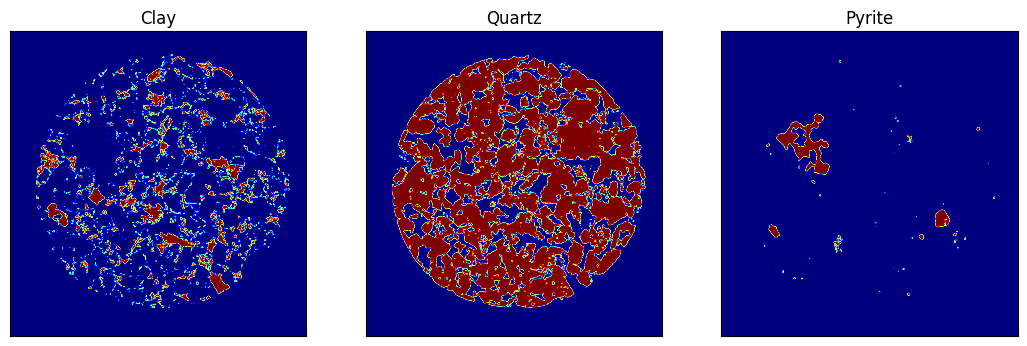

In [27]:
plt.figure(figsize= (13, 13))
label_list = {
    1: 'Air',
    2: 'Clay',
    3: 'Quartz',
    4: 'Pyrite'
}
for i in range(3):
    plt.subplot(1, 3, i + 1)
    fig = plt.imshow(segmented_img_test == i + 2, cmap= 'jet')
    fig = plt.title(label_list.get(i + 2))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    